# Import Packages and Dataset

In [ ]:
# import packages
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import math
import gc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

In [ ]:
rseed = 42

In [ ]:
#import Data
df=pd.read_csv("./data/air_quality_final.csv")

# XGBoost Model

In [18]:
X = df.drop('target', axis=1)
y = df['target']
print(f"We have {X.shape[0]} observations in our dataset and {X.shape[1]} features")
print(f"Our target vector has also {y.shape[0]} values")

We have 14833 observations in our dataset and 24 features
Our target vector has also 14833 values


In [22]:
#dummy-encode the location feature
location = pd.get_dummies(X['location'], prefix='location',drop_first=True)
location.head()
# concatenate dummy-encoded locations feature to original dataframe
X = pd.concat([X, location],axis = 1)

,location,time_of_day_cos,time_of_day_sin,last_temp,last_precip,last_rel_humidity,last_wind_dir_x,last_wind_dir_y,last_wind_spd,last_atmos_press,...,mean_wind_dir_y,std_wind_dir_y,mean_wind_spd,std_wind_spd,mean_atmos_press,std_atmos_press,location_B,location_C,location_D,location_E
0,C,0.673064,0.739584,19.583333,0.000,0.874583,0.823917,-0.566710,0.855000,87.768333,...,0.041438,0.668359,0.677348,0.394041,87.752434,0.070374,0,1,0,0
1,D,-0.513582,-0.858040,21.450000,0.561,0.797333,0.453481,-0.891266,1.019167,90.529167,...,0.146340,0.738142,0.899208,0.539199,90.429924,0.156000,0,0,1,0
2,A,-0.807017,0.590529,30.091667,0.000,0.437917,-0.340293,-0.940319,1.746667,88.415833,...,-0.146329,0.647675,1.038656,0.585221,88.420931,0.179481,0,0,0,0
3,A,-0.822432,0.568864,24.641667,0.000,0.719667,0.875622,-0.482997,1.852500,88.465833,...,-0.246912,0.500793,1.365202,0.580259,88.376915,0.161758,0,0,0,0
5,E,-0.166232,0.986087,25.075000,0.000,0.773000,-0.819840,0.572592,1.301667,88.510000,...,0.175220,0.524133,1.133221,0.531331,88.437645,0.147604,0,0,0,1


In [39]:
#train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=X['location'], random_state=rseed)

In [40]:
#drop multiclass location column
X_train_loc = X_train.location
X_test_loc = X_test.location
X_train.drop('location', axis=1, inplace=True)
X_test.drop('location', axis=1, inplace=True)

In [29]:
from xgboost import XGBRegressor, XGBClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

## intermission: Simple base model

In [41]:
#train a simple base model
xgb = XGBRegressor()
xgb.fit(X_train, y_train)

y_pred_base = xgb.predict(X_test)

In [42]:
# evaluate model accurray
rmse_base = mean_squared_error(y_test, y_pred_base, squared=False)
r2_base = r2_score(y_test, y_pred_base)

print(f'RMSE on testset: {round(rmse_base,2)}')
print(f'Coefficient of determination on testset: {round(r2_base,2)}')

RMSE on testset: 24.98
Coefficient of determination on testset: 0.65


In [43]:
# calculate residuals
residual_base = y_test - y_pred_base

# compute mean of residuals
np.mean(residual_base)

-0.27460779320810735

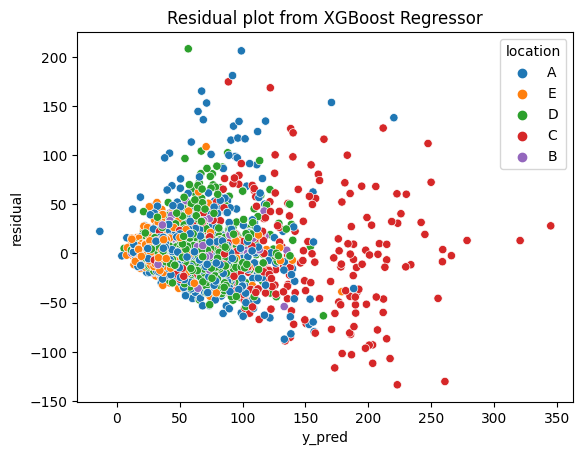

In [44]:
sns.scatterplot(x=y_pred_base, y=residual_base, hue=X_test_loc)
plt.xlabel('y_pred')
plt.ylabel('residual')
plt.title('Residual plot from XGBoost Regressor');

## back to serious business

In [45]:
xgb_params = {'n_estimators': [150, 175, 200, 225, 250],
                'max_depth': [5, 7, 10, 12, 15, 20],
                'max_leaves': [20, 40, 60, 80, 100, 120]}

grid_xgb = GridSearchCV(XGBRegressor(seed=42), xgb_params, scoring='neg_root_mean_squared_error',
                  cv=5, verbose=0, n_jobs=-1)

grid_xgb.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                  

>This model's results:
RMSE: 24.47
R2: .66
Best parameters: {‘max_depth’: 7, ‘max_leaves’: 20, ‘n_estimators’: 225}

In [58]:
xgb_params = {'n_estimators': [200, 210, 220, 225, 230, 240, 500],
                'max_depth': [6, 7, 8, 9],
                'max_leaves': [15, 20, 25, 30, 35, 40]}

grid_xgb = GridSearchCV(XGBRegressor(seed=42), xgb_params, scoring='neg_root_mean_squared_error',
                  cv=5, verbose=0, n_jobs=-1)

grid_xgb.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                  

In [59]:
# Best score
print('Best score:', round(grid_xgb.best_score_, 3))

# Best parameters
print('Best parameters:', grid_xgb.best_params_)

Best score: -25.954
Best parameters: {'max_depth': 7, 'max_leaves': 15, 'n_estimators': 220}


#### retrain on whole training set

In [60]:
# save best model
xgb_best = grid_xgb.best_estimator_
xgb_best

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=7, max_leaves=15, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=220, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, ...)

In [61]:
xgb_best.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=7, max_leaves=15, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=220, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, ...)

In [62]:
y_pred_xgb = xgb_best.predict(X_test)

In [64]:
# evaluate model accurray
rmse_xgb = mean_squared_error(y_test, y_pred_xgb, squared=False)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f'RMSE on testset: {round(rmse_xgb,2)}')
print(f'Coefficient of determination on testset: {round(r2_xgb,2)}')

RMSE on testset: 24.47
Coefficient of determination on testset: 0.66


In [65]:
# calculate residuals
residual_xgb = y_test - y_pred_xgb

# compute mean of residuals
np.mean(residual_xgb)

-0.13829705864825334

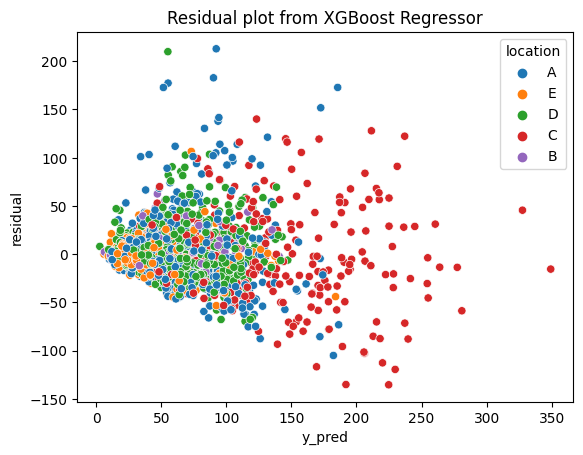

In [66]:
sns.scatterplot(x=y_pred_xgb, y=residual_xgb, hue=X_test_loc)
plt.xlabel('y_pred')
plt.ylabel('residual')
plt.title('Residual plot from XGBoost Regressor');

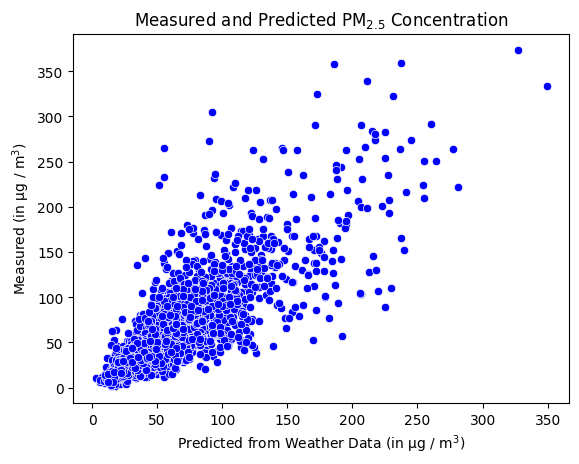

In [90]:
sns.scatterplot(x=y_pred_xgb, y=y_test, color='b')#, hue=X_test_loc)
plt.xlabel('Predicted from Weather Data (in µg / m$^3$)')
plt.ylabel('Measured (in µg / m$^3$)')
plt.title('Measured and Predicted PM$_{2.5}$ Concentration');

### Convert actual and predicted PM2.5 levels from best models into air quality categories

In [93]:
# plotting function for color-coded confusion matrix
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('Measured Category', size = 18)
    plt.xlabel('Predicted Category', size = 18)

In [91]:
# actual y labels
y_test_labels = ['Good' if x < 13 else 'Moderate' if x < 36 else 'Unhealthy (Sensitive)' if x < 56 else 'Unhealthy' if x < 151 
                    else 'Very Unhealthy' if x < 251 else 'Hazardous' for x in y_test]

# predicted y labels by XGBoost Regressor
y_pred_labels = ['Good' if x < 13 else 'Moderate' if x < 36 else 'Unhealthy (Sensitive)' if x < 56 else 'Unhealthy' if x < 151 
                    else 'Very Unhealthy' if x < 251 else 'Hazardous' for x in y_pred_xgb]

### Compute confusion matrix and plot

In [69]:
cm = confusion_matrix(y_test_labels, y_pred_labels)

Confusion matrix, without normalization


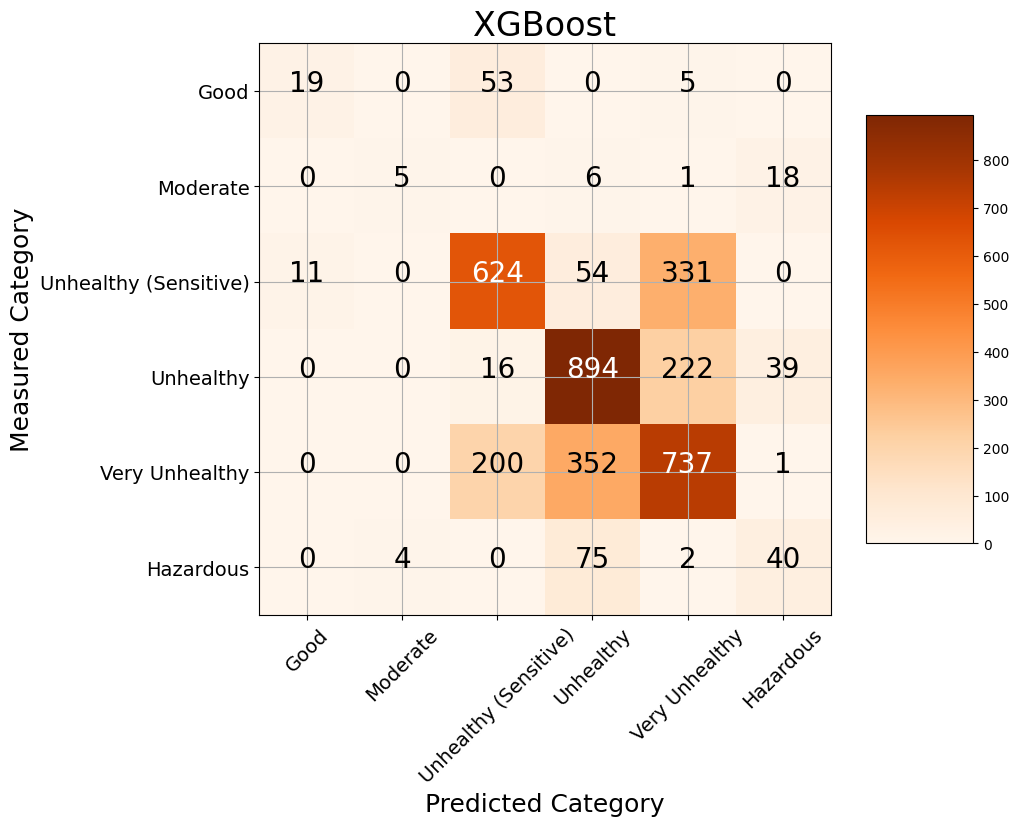

In [94]:
plot_confusion_matrix(cm, classes=['Good', 'Moderate', 'Unhealthy (Sensitive)', 'Unhealthy', 'Very Unhealthy', 'Hazardous'],
                title='XGBoost');

In [95]:
from sklearn.inspection import permutation_importance

In [96]:
xgb_best.feature_importances_

array([0.00792104, 0.04177828, 0.00941283, 0.00479403, 0.00769826,
       0.00488024, 0.00539026, 0.01025935, 0.0149484 , 0.01099163,
       0.01120479, 0.01597627, 0.02303094, 0.01496527, 0.0105255 ,
       0.03048126, 0.01610476, 0.01141432, 0.0098767 , 0.0176097 ,
       0.01275645, 0.07228589, 0.01349653, 0.02819038, 0.        ,
       0.        , 0.59400696], dtype=float32)

<BarContainer object of 27 artists>

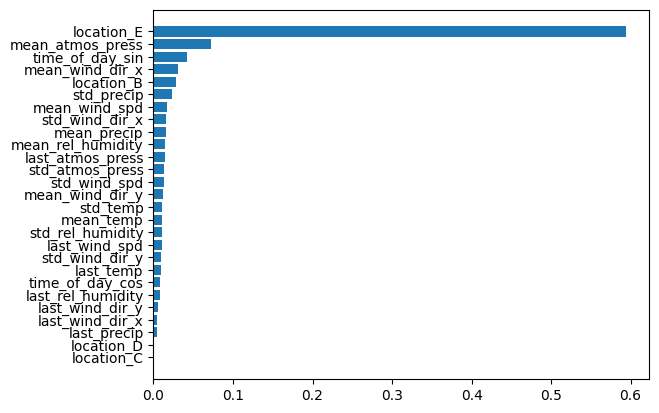

In [101]:
sorted_features = xgb_best.feature_importances_.argsort()

plt.barh(X_train.columns[sorted_features], xgb_best.feature_importances_[sorted_features])

Text(0.5, 0, 'Permutation Importance')

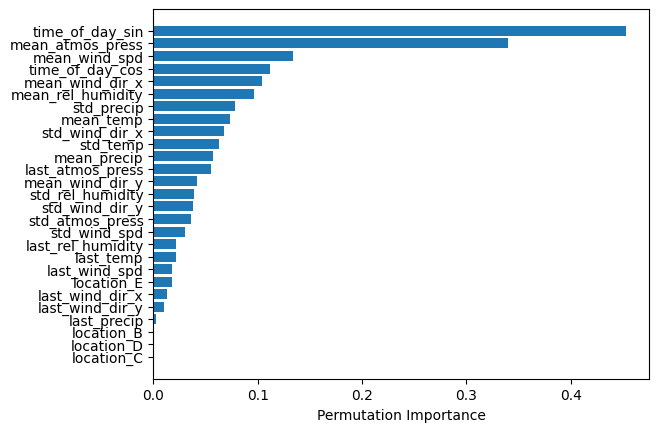

In [102]:
perm_importance = permutation_importance(xgb_best, X_test, y_test)

sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(X_train.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")